# Local or Stochastic? 

#### *You’re never fully dressed without a smile.*

*— Martin Charnin*

We offer you the following practical task on local and stochastic volatility models.

Total score is 100, which will be converted to  of the course grade. You have almost 4 weeks for this work. Soft deadline is 25th of May, 23:00 MSK. Every 24 hours during the next week after the deadline will give a 10 points penalty. Hard deadline is 29th of May, 23:00 MSK.

The file must be sent to victorantipov99@gmail.com **with copy** to igudav@ya.ru (works sent to only one reviewer will not be reviewed 😜) **with topic** "stoch-vol hw2". **WARNING: topic is important! Inbox will be filtered automatcally based on exact match.** Please rename your file as "SurnameName_HW2.ipynb" before sending.

If you have any questions feel free to ask in Telegram https://t.me/igortao or https://t.me/v_antipov.

Full name:

Faculty:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm

from dataclasses import dataclass
from typing import Union, Callable, Optional
from copy import deepcopy
from scipy.optimize import root_scalar, brentq
from dataclasses import dataclass

import warnings
from  scipy.stats import norm
warnings.filterwarnings("ignore")

In [12]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

In [13]:
@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    interest_rate: Union[float, np.ndarray]  # r, assume constant

---

## Episode 1: Local volatility calibration (30 points) 🧠

Consider the local volatility model:
$$
dS_t = S_t r\,dt + S_t \sigma(t, S_t)\,dW_t,\\
d \log S_t = \left(r - \frac{\sigma(t, S_t)^2}{2}\right)\,dt + \sigma(t, S_t)\,dW_t.
$$

Recall the Dupire's formula, that maps call market prices to <span style="color:blue">(10 points)</span>: 

$$
\sigma(t, s) = \sqrt{\frac{2C^{}_{T}(t,s)+rsC^{}_{K}(t,s) }{s^{2}C^{}_{KK}(t,s)}}
$$

The formula above includes derivatives of call price w.r.t. strike and time.
Since we know the market call prices only at specific points, interpolation is needed to recover the local volatility function.
We will use bivariate spline to interpolate call prices surface.
Spline of order $k$ has continuous derivatives of orders up to $k-1$.
To obtain continuous second order derivative we need to use cubic bivariate spline for interpolation.

Write function which calculates local volatility from option prices and interpolates it <span style="color:blue">(20 points)</span>.

In [14]:
from scipy.interpolate import RectBivariateSpline

In [15]:
def make_local_vol_func(calls: CallStockOption,
                        call_prices: np.ndarray,
                        interest_rate: float = 0) -> Callable[[float, float], float]:
    """Returns local volatility function given market call prices
    
    Important note: the arguments of the spline call can be interpreted
    two different ways base on boolean parameter ``grid``. If set to True,
    ``x`` and ``y`` (if are 1-dimenstional arrays) are broadcasted to
    meshgrid and the spline will be evaluated in grid points. In this
    case the values in arrays must be sorted. But for compatibility with
    other code, parameter ``grid`` shoud be set to False. In this case the
    spline will be evaluated in points (x[i], y[i]), which is what we need.
    
    Args:
        calls (CallStockOption): an object of type CallStockOption.
            The attributes are the points at which market call prices are observed.
        call_prices (np.ndarray): matrix of call prices evaluated at given points.
            The dimensions are (time, strikes).
        interest_rate (float): the risk-free rate.
        
    Returns:
        function that evaluates local volatility (not variance!) at given point
    """
    
    # It is recommended, first, to caculate numerical derivatives (use np.gradient),
    # evaluate the LV function at given points and only then interpolate
    # YOU CODE HERE
    r=interest_rate
    T=calls.expiration_time #T len=15
    K=calls.strike_price #K len=16
    C=call_prices #15*16
    C_T=np.gradient(C,T,axis=0) #T-for x_i,C-for fi
    C_K=np.gradient(C,K,axis=1) #K-for x_i,C-for fi
    C_KK=np.gradient(C_K,K,axis=1)
    sigma=(2*C_T+r*K*C_K)/(K*K*C_KK+1e-10)
    sigma[sigma<0]=0
    sigma=np.sqrt(sigma)
    interpolation=RectBivariateSpline(T,K,sigma)

    def local_vol_func(t, s):
        # YOU CODE HERE
        # in this funciton you can use all arguments of enclosing funciton
        # use `grid=False` in call to the spline
        return interpolation(t,s,grid=False)
    
    return local_vol_func

Let's look at the local volatility function fitted to real market data.

Functions for ImpVol calculation:

In [16]:
def dt(option: StockOption):
    return np.maximum(option.expiration_time, np.finfo(np.float64).eps)

def d1(option: StockOption, state: MarketState, vola: float):
    return 1 / (vola * np.sqrt(dt(option)))\
                * (np.log(state.stock_price / option.strike_price)
                   + (state.interest_rate + vola ** 2) * dt(option))

def d2(option: StockOption, state: MarketState, vola: float):
    return d1(option, state, vola) - vola * np.sqrt(dt(option))
    
def price(option: StockOption, state: MarketState, vola: float):
    discount_factor = np.exp(-state.interest_rate * (dt(option)))
    if option.is_call:
        return sps.norm.cdf(d1(option, state, vola)) * state.stock_price\
            - sps.norm.cdf(d2(option, state, vola)) * option.strike_price * discount_factor
    
    return sps.norm.cdf(-d2(option, state, vola)) * option.strike_price * discount_factor\
        - sps.norm.cdf(-d1(option, state, vola)) * state.stock_price

def vega(option: StockOption, state: MarketState, vola: float):
    return state.stock_price * sps.norm.pdf(d1(option, state, vola)) * np.sqrt(dt(option))

def calc_imp_vol(option: CallStockOption, state: MarketState, option_price: float):
    
    RTOL = 1e-16
    ATOL = 1e-16
    VOL_MIN = 0.0
    VOL_MAX = 1.0
    MAX_ITER = 100
    
    vola = 0.2
    p = price(option, state, vola)

    lb = VOL_MIN
    rb = VOL_MAX
    
    for i in range(MAX_ITER):
        
        resid = price(option, state, vola) - option_price
        if abs(resid) < ATOL and abs(resid) / (option_price + np.finfo(np.float64).eps) < RTOL:
            break
        
        newton_ok = False
        
        # try Newton
        v = vega(option, state, vola)
        if abs(v) > np.finfo(np.float64).eps:
            new_vola = vola - (p - option_price) / v
            if lb < new_vola < rb:
                newton_ok = True
        
        # if something went wrong, bisect
        if not newton_ok:
            new_vola = (lb + rb) / 2

        new_p = price(option, state, new_vola)
        if new_p > option_price:
            rb = new_vola
        else:
            lb = new_vola
        
        vola = new_vola
        p = new_p
        
    return vola

In [17]:
with np.load("call_prices.npz") as f:
    observed_calls = CallStockOption(strike_price=f["strikes"],
                                     expiration_time=f["expiration_times"])
    observed_call_prices = f["call_prices"]
    observed_market_state = MarketState(stock_price=1.0,
                                        interest_rate=0.0)

In [18]:
imp_vol = np.empty_like(observed_call_prices)

for i in range(len(observed_calls.expiration_time)):
    for j in range(len(observed_calls.strike_price)):
        imp_vol[i, j] = calc_imp_vol(option=CallStockOption(observed_calls.strike_price[j], observed_calls.expiration_time[i]), 
                           state=observed_market_state, 
                           option_price=observed_call_prices[i, j])

In [19]:
loc_vol_func = make_local_vol_func(calls=observed_calls,
                              call_prices=observed_call_prices)

It's OK to have some numerical instability of local volatility function in the corners.

Text(0.5, 0, 'Imp_Vol')

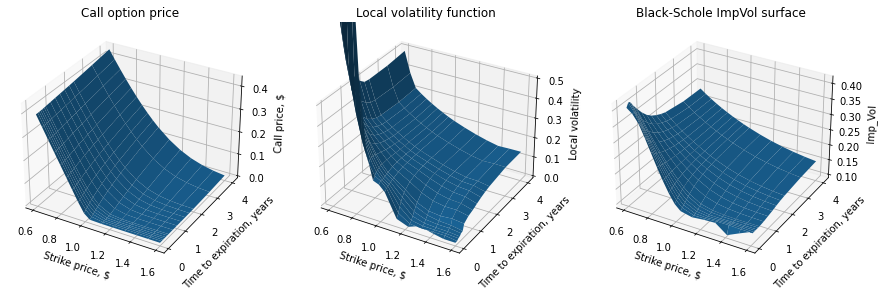

In [20]:
K, T = np.meshgrid(observed_calls.strike_price,
                   observed_calls.expiration_time)
loc_vol = loc_vol_func(T, K)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(K, T, observed_call_prices)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Call price, $')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K, T, loc_vol)
ax2.set_title('Local volatility function')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Local volatility')
ax2.set_zlim(0.0, 0.5)

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(K, T, imp_vol)
ax3.set_title('Black-Schole ImpVol surface')
ax3.set_xlabel('Strike price, $')
ax3.set_ylabel('Time to expiration, years')
ax3.set_zlabel('Imp_Vol')

---

## Episode 2: Monte-Carlo pricing in LV model (25 points) 🧠

There are several method for pricing with local volatility:
- Monte-Carlo,
- Binomial trees,
- Trinomial trees (aka finite difference PDE solving),
- etc.

Here we will use vanilla MC. Write function which calculates MC option prices in local volatility model <span style="color:blue">(25 points)</span>.

$$
dS_t = S_t r\,dt + S_t \sigma(t, S_t)\,dW_t\\
d \log S_t = \left(r - \frac{\sigma(t, S_t)^2}{2}\right)\,dt + \sigma(t, S_t)\,dW_t.
$$

In [21]:
def mc_call_price_with_loc_vol(option: CallStockOption,
                     ms: MarketState,
                     local_vol_func: Callable[[float, float], float],
                     dt: float = 1e-2,
                     n_paths: int = 10000,
                     random_state: int = 0) -> float:
    """Returns option price in LV model, calculated using MC simulation
    
    Args:
        option (CallStockOption): ONE call option (all its attributes are floats).
        ms (MarketState): a state of a market in which option shoud be priced.
        local_vol_fun (Callable): function that accepts time and stock price and
            returns local volatility at that point. The function must accept arrays
            and interpret them as pairs of arguments at which the local volatility
            shoud be evaluated.
        dt (float): time step for Euler discretization.
        n_paths (int): number of MC paths.
        random_state (int): random seed for np.random.seed for reproducibility.
    
    Returns:
        float: option price    
    """
    np.random.seed(random_state)
    T=option.expiration_time
    K=option.strike_price
    S0=ms.stock_price
    r=ms.interest_rate
    logSt=np.log(S0)*np.ones(n_paths).reshape(n_paths,1)
    t=0
    while(t<=T):
        dWt=np.sqrt(dt)*np.random.normal(loc=0,scale=1,size=n_paths).reshape(n_paths,1)
        sigma=local_vol_func(t,np.exp(logSt))
        sigma=np.maximum(sigma,0)
        logSt+=(r-sigma*sigma/2)*dt+sigma*dWt
        t+=dt
    St=np.exp(logSt)
    return np.exp(-r*T)*np.maximum(St-K,0).mean()

In [22]:
time_idx = 12

t = observed_calls.expiration_time[time_idx]
strikes = np.arange(.5, 1.6, .1)
vola_smile = np.empty_like(strikes)
p = np.empty_like(strikes)

for i, k in enumerate(tqdm(strikes)):
    option = CallStockOption(strike_price=k, expiration_time=t)
    p[i] = mc_call_price_with_loc_vol(option, observed_market_state, loc_vol_func)
    #print(p[i])
    vola_smile[i] = calc_imp_vol(option, observed_market_state, p[i])

  0%|          | 0/11 [00:00<?, ?it/s]

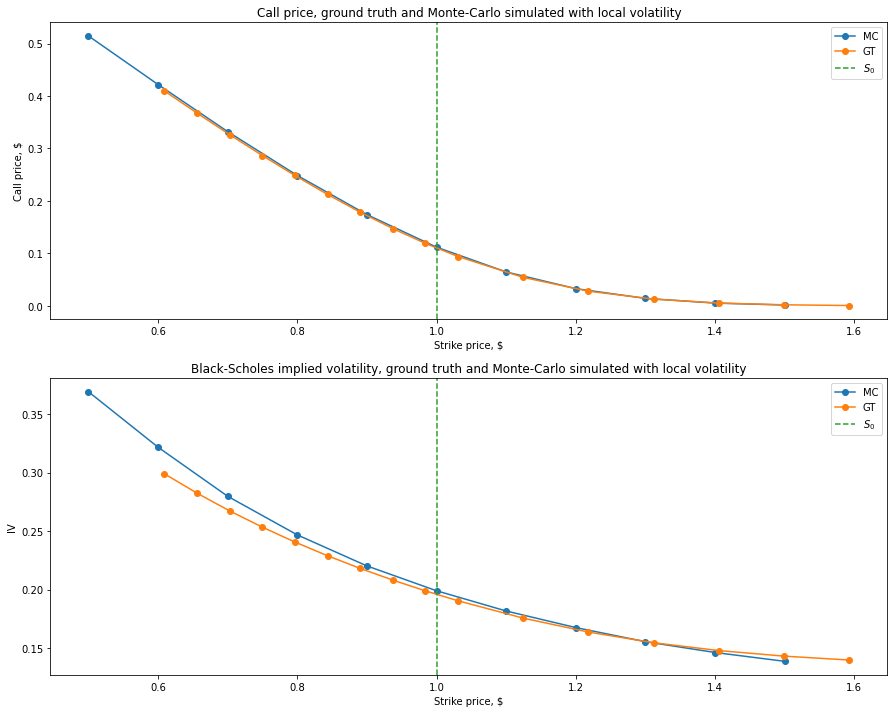

In [23]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(strikes, p, "-o", label="MC")
ax1.plot(observed_calls.strike_price, observed_call_prices[time_idx], "-o", label="GT")
ax1.axvline(x=1.0, label="$S_0$", ls='--', c='C2')
ax1.set_xlabel("Strike price, $")
ax1.set_ylabel("Call price, $")
ax1.set_title("Call price, ground truth and Monte-Carlo simulated with local volatility")
ax1.legend()

ax2.plot(strikes, vola_smile, "-o", label="MC")
ax2.plot(observed_calls.strike_price, imp_vol[time_idx], "-o", label="GT")
ax2.axvline(x=1.0, label="$S_0$", ls='--', c='C2')
ax2.set_xlabel("Strike price, $")
ax2.set_ylabel("IV")
ax2.set_title("Black-Scholes implied volatility, ground truth and Monte-Carlo simulated with local volatility")
ax2.legend()

plt.show()

## Episode 3: Incorrect dynamics (1 point) 💅

Just enjoy this part without writing any code. Moreover, the code below may help you to do the previous task correctly.

Let's MC the prices for different initial stock price.

In [24]:
init_iv = np.empty_like(strikes)
for i, k in enumerate(strikes):
    option = CallStockOption(strike_price=k, expiration_time=t)
    p = mc_call_price_with_loc_vol(option, observed_market_state, loc_vol_func, n_paths=1000, dt=1e-2)
    init_iv[i] = calc_imp_vol(option, observed_market_state, p)

def plot_iv_for_s0(stock_price: float):
    time_idx = 12

    t = observed_calls.expiration_time[time_idx]
    vola_smile = np.empty_like(strikes)
    market_state = MarketState(stock_price=stock_price, interest_rate=0)
    
    for i, k in enumerate(strikes):
        option = CallStockOption(strike_price=k, expiration_time=t)
        p = mc_call_price_with_loc_vol(option, market_state, loc_vol_func, n_paths=1000, dt=1e-2)
        vola_smile[i] = calc_imp_vol(option, market_state, p)
        
    _, ax = plt.subplots(figsize=(15, 5))
    ax.plot(strikes, init_iv, ":", label="IV for $S_0=1.0$", c="C0")
    ax.plot(strikes, vola_smile, "-o", label=f"IV for $S_0={stock_price:.3}$", c="C0")
    ax.axvline(x=stock_price, label="$S_0$", ls='--', c="C1")
    ax.set_xlim(.45, 1.55)
    ax.set_ylim(.1, 1.)
    ax.set_xlabel("Strike price, $")
    ax.set_ylabel("IV")
    ax.set_title("Black-Scholes implied volatility for different initial stock prices")
    ax.legend()
    plt.show()

In [25]:
interact(plot_iv_for_s0,
         stock_price=widgets.FloatSlider(min=.8, max=1.3, value=1.0, step=0.01, description='Stock price'))

interactive(children=(FloatSlider(value=1.0, description='Stock price', max=1.3, min=0.8, step=0.01), Output()…

<function __main__.plot_iv_for_s0(stock_price: float)>

---

## "Heston, we have a problem"

## Episode 4: Heston simulations (34 points) 🧠

Heston model can be written in following way:

$$dS_t/S_t  = rdt + \sqrt{V_t} dW_1$$

$$dV_t = \kappa (\bar V-V_t)dt + \gamma \sqrt V_t dW_2$$

$$dW_1 dW_2 = \rho dt$$

In [26]:
@dataclass
class HestonParameters:
    kappa:  Union[float, np.ndarray]
    gamma:  Union[float, np.ndarray]
    rho:  Union[float, np.ndarray]
    vbar:  Union[float, np.ndarray]
    v0:  Union[float, np.ndarray]

**1.1 Euler approach** <span style="color:blue">(17 points)</span>

$$
d \log S_t = \left(r - \frac{\sigma(t, S_t)^2}{2}\right)\,dt + \sigma(t, S_t)\,dW_t.
$$

It can be simulated in discrete time using Euler scheme by selecting a time step $∆t$ starting at $S_0, V_0$:

$$\log s_{i} = \log s_{i-1} + (r - v_{i-1}/2)\Delta t+ \sqrt{v_{i-1} \Delta t}(  ρε^1_{i} + \sqrt{1- ρ^2} ε^2_{i})],$$

$$v_{i} =  v_{i-1} + \kappa (\bar V-v_{i-1})\Delta t + \gamma \sqrt{ v_{i-1} \Delta t}ε^1_{i}$$.

In [27]:
def simulate_paths_heston_euler(time: Union[float, np.ndarray],
                                n_simulations: int,
                                state: MarketState,
                                heston_params: HestonParameters) -> dict:
    """Simulates price and volatility process evaluating it at given time points 
       using Euler scheme. 
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market state to start from.
        heston_params (HestonParameters): parameters of Heston model.
        
    Returns:
        dict: simulated asset and volatility paths.
    """
    
    # initialize market and model parameters
    r, S0 = state.interest_rate, state.stock_price
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    ## initialize noise arrays
    Z1 = np.random.normal(size=(n_simulations, np.shape(time)[0]))
    Z2 = np.random.normal(size=(n_simulations, np.shape(time)[0]))
    
    #initialize zero array for volatility values
    V = np.zeros([n_simulations, np.shape(time)[0]])
    V[:, 0] = v0
    
    #initialize zero array for logprice values
    logS = np.zeros([n_simulations, np.shape(time)[0]])
    logS[:, 0] = np.log(S0) 
    
    # YOUR CODE HERE
    # Hint 1:
    #     You need to iterate in time and calculate logS[:, ind + 1] and V[:,ind + 1] given 
    #     logS[:, ind] and V[:, ind]. Notice that the V[:, ind] values may be negative, so you 
    #     may reflect them positively or truncate it (take (max(V[:, ind], 0)).
    #
    # Hint 2: 
    #     You may use cycles if you wish. However, it is possible 
    #     to code it in a vectorized form.
    #----------------------------------------------------------------------------------------
    tjm1=0
    for j in range(1,np.shape(time)[0]):
        tj=time[j]
        dt=tj-tjm1
        if (dt<1e-15):
            V[:,j]=v0
            logS[:,j] = np.log(S0) 
            continue
        dWt1=np.sqrt(dt)*Z1[:,j]
        dWt2=np.sqrt(dt)*Z2[:,j]
        logS[:,j]=logS[:,j-1]+(r-0.5*V[:,j-1])*dt+np.sqrt(V[:,j-1])*(heston_params.rho*dWt1+np.sqrt(1-heston_params.rho**2)*dWt2)
        Vtj=V[:,j-1]+heston_params.kappa*(heston_params.vbar-V[:,j-1])*dt + heston_params.gamma*np.sqrt(V[:,j-1])*dWt1
        Vtj[Vtj<0]=0
        V[:,j]=Vtj.reshape(n_simulations)
        tjm1=tj
    #---------------------------------------------------------------------------------------- 
    
    #put the calculated values into the dictionary
    simulated_paths = {"asset": np.exp(logS), "volatility": V}
    
    return simulated_paths

In [28]:
time = np.linspace(0, 2, 500)
heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, 
                                     rho = -0.3937, vbar = 0.0641, 
                                     v0 = 0.3)

state = MarketState(stock_price = 1, interest_rate = 0.01)

n_simulations = 10000

paths = simulate_paths_heston_euler(time, n_simulations, state, heston_parameters)

assert type(paths) == dict, "Paths type is not a dict, see function simulate_paths_heston_euler"
assert paths["asset"].shape == (n_simulations, len(time)), "Asset paths shape is not [n_sims, n_times]"
assert paths["volatility"].shape == paths["asset"].shape, "Volatility paths shape is not equal to asset paths shape"
assert np.all(paths["volatility"] >= 0), "You get negative volatilities"
assert np.isnan(paths["asset"]).sum() == 0, "You get nan asset values"
assert np.isnan(paths["volatility"]).sum() == 0, "You get nan volatility values"
print("Well done!")

Well done!


In [29]:
def plot_random_paths(times: np.array, 
                      simulated_paths: dict,
                      type_of_scheme: str = "Euler",
                      plot_paths: int = 15):
    """Plots some simulated paths.
    
    Args:
        simulated_paths (dict): paths of an asset and volatility values.
    """
    #take random paths indexes
    n_simulatinos = simulated_paths["asset"].shape[0]
    random_indexes = np.random.choice(n_simulatinos, plot_paths)
    
    #take paths corresponding to sampled indexes
    asset_paths = simulated_paths["asset"][random_indexes]
    volatility_paths = simulated_paths["volatility"][random_indexes]
    
    #plot asset prices and volatilities 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,9))
    fig.suptitle("{} scheme simulated Heston model".format(type_of_scheme))    
    fig.subplots_adjust(hspace=0.4)
    
    for i in range(plot_paths):
        ax1.plot(times, asset_paths[i])
        ax2.plot(times, volatility_paths[i])
        
    ax1.set_xlabel('time')
    ax1.set_ylabel('Asset')
    ax1.grid(True)
    
    ax2.set_xlabel('time')
    ax2.set_ylabel('Volatility')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()  

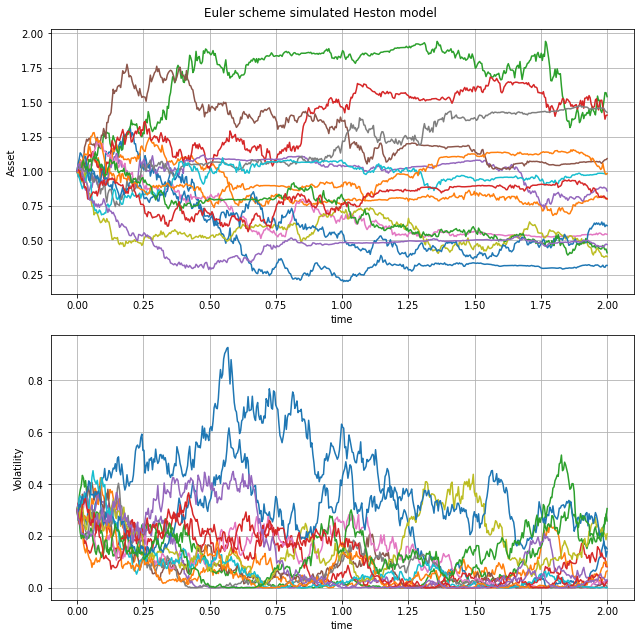

In [30]:
plot_random_paths(time, paths)

**1.2. Broadie-Kaya approach** <span style="color:blue">(17 points)</span>

This approach gives an alternative way of simulating the process. Expressing the stochastic integral from variance process and substituting it into the log price process, gives the following scheme formula

$$\log s_i = \log s_{i-1} + (r - v_{i-1}/2)dt +   \frac{\rho}{\gamma}(v_i - v_{i-1}  - \kappa (\bar v - v_{i-1})dt) +  \sqrt{(1-\rho^2) \Delta t}  \sqrt{v_{i-1}} \varepsilon_i.$$

At the same time, variance values can be sampled from the following $\chi^2$ distribution

$$v_{i} \sim c(t_{i-1}, t_i) \chi^2(\delta, \bar \kappa(t_{i-1}, t_i)),$$

where $c(t_{i-1}, t_i) = \dfrac{\gamma^2}{4 \kappa} (1 - e^{-\kappa (t_i - t_{i-1})})$, $\delta = \dfrac{4 \kappa \bar v}{\gamma^2 }$, $\bar \kappa (t_i, t_{i-1}) = \dfrac{4 \kappa e^{-\kappa \Delta t}}{\gamma^2 (1 - e^{-\kappa \Delta t})} v_i.$

In [31]:
def cir_chi_sq_sample(heston_params: HestonParameters,
                      dt: float,
                      v_im1: np.array,
                      n_simulations: int):
    """Samples chi_sqqred statistics for v_{i} conditional on 
       v_{i-1} and parameters of Hestom model. 
        
    Args:
        heston_params (HestonParameters): parameters of Heston model
        dt (float): time step 
        v_i: current volatility value
        n_simulations (int): number of simulations.
        
    Returns:
        np.array: sampled chi_squared statistics 
    """
    kappa, vbar, gamma = heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    # YOUR COED HERE:
    # calculate \delta, c and \kappabar from Heston parameters and sample the value from
    # noncentral chi square distribution.
    # Hint 1: 
    #     Use np.random.noncentral_chisquare(...)
    #--------------------------------------------
    c=gamma**2/(4*kappa)*(1-np.exp(-kappa*dt))
    delta=4*kappa*vbar/(gamma**2)
    kappabar=4*kappa*np.exp(-kappa*dt)/(gamma*gamma*(1-np.exp(-kappa*dt)))*v_im1
    sample=c*np.random.noncentral_chisquare(delta,kappabar,size = n_simulations)
    #--------------------------------------------
    return  sample

In [32]:
def simulate_paths_heston_bk(time: Union[float, np.ndarray],
                              n_simulations: int,
                              state: MarketState,
                              heston_params: HestonParameters) -> dict:
    """Simulates price and volatility process evaluating it at given time points 
       using Broadie-Kaya scheme. 
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market state to start from.
        heston_params (HestonParameters): parameters of Heston model.
        
    Returns:
        dict: simulated asset and volatility paths
    """
    
    # initialize market and model parameters
    r, s0 = state.interest_rate, state.stock_price
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    # initialize noise array
    Z1 = np.random.normal(size=(n_simulations, np.shape(time)[0]))
    
    # initialize zero array for volatility values
    V = np.zeros([n_simulations, np.shape(time)[0]])
    V[:, 0] = v0
    
    # initialize zero array for log price values
    logS = np.zeros([n_simulations, np.shape(time)[0]])
    logS[:, 0] = np.log(s0)
    
    # YOUR CODE HERE
    # Hint 1:
    #     You need to iterate in time and calculate logS[:, ind + 1] and V[:,ind + 1] given 
    #     logS[:, ind] and V[:, ind]. Notice that the V[:, ind] values may be negative, so you 
    #     may reflect the the positively or truncate it (take (max(V[:, ind], 0)).
    #
    # Hint 2: 
    #     You may use cycles if you wish. However, it is possible 
    #     to code it in a vectorized form.
    # Hint 3:
    #     In order to get chi^2 sample, just call the cir_chi_sq_sample(...) function.
    #----------------------------------------------------------------------------------------
    tjm1=time[0]
    for j in range(1,len(time)):
        tj=time[j]
        dt=tj-tjm1
        if (dt<1e-15):
            V[:,j]=v0
            logS[:,j] = np.log(S0) 
            continue
        Vj=cir_chi_sq_sample(heston_params,dt,V[:,j-1],n_simulations).reshape(n_simulations,1)
        Vj[Vj<0]=0
        V[:,j]=Vj.reshape(n_simulations)
        logS[:,j]=logS[:,j-1]+(r-0.5*V[:,j-1])*dt + rho/gamma*(V[:,j]-V[:,j-1]-kappa*(vbar-V[:,j-1])*dt) +np.sqrt(1-rho**2)*np.sqrt(dt)*np.sqrt(V[:,j-1])*Z1[:,j]
        tjm1=tj
    #----------------------------------------------------------------------------------------
    
    simulated_paths = {"asset": np.exp(logS), "volatility": V}
    
    return simulated_paths

In [33]:
time = np.linspace(0, 2, 500)
heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, 
                                     rho = -0.3937, vbar = 0.0641, 
                                     v0 = 0.3)

state = MarketState(stock_price = 1, interest_rate = 0.01)

n_simulations = 10000

paths = simulate_paths_heston_bk(time, n_simulations, state, heston_parameters)

assert type(paths) == dict, "Paths type is not a dict, see function simulate_paths_heston_euler"
assert paths["asset"].shape == (n_simulations, len(time)), "Asset paths shape is not [n_sims, n_times]"
assert paths["volatility"].shape == paths["asset"].shape, "Volatility paths shape is not equal to asset paths shape"
assert np.all(paths["volatility"] >= 0), "You get negative volatilities"
assert np.isnan(paths["asset"]).sum() == 0, "You get nan asset values"
assert np.isnan(paths["volatility"]).sum() == 0, "You get nan volatility values"
print("Well done!")

Well done!


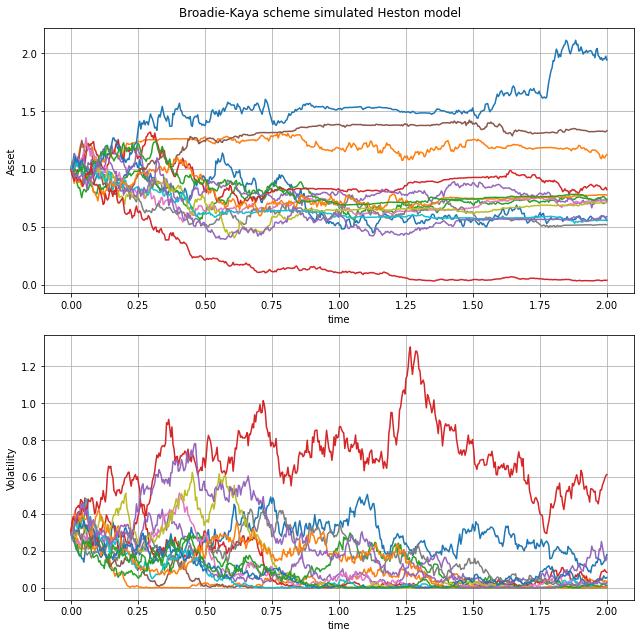

In [34]:
plot_random_paths(time, paths, type_of_scheme="Broadie-Kaya")

Having implemented functions, which generate Heston trajectories with Euler and Broadie-Kaya schemes, we are ready to calculate option prices using monte carlo approach. 

In [35]:
def present_value(time: Union[float, np.ndarray],
                  value: Union[float, np.ndarray],
                  interest_rate: float) -> Union[float, np.ndarray]:
    """Calculates present value of payoff(s) occuread at given time(s)
    
    Args:
        time (float or np.ndarray): time(s) in years at which payoff occured
        value (float or np.ndarray): value(s) of the payoff(s)
        interest_rate (float): continuous annualized constant discount rate
    
    Returns:
        float or np.ndarray: continuously discounted value
    """ 
    return np.exp(-interest_rate * time) * value

In [36]:
def mc_price(option: StockOption, 
             state: MarketState, 
             heston_parameters: HestonParameters,
             n_simulations: int = 10_000,
             type_of_scheme: str = "Euler"):
    """Calculates MC price of an option.
    
     Args:
        option(StockOption): call or put option.
        state (MarketState): initial market state to start from.
        heston_params (HestonParameters): parameters of Heston model. 
        n_simulations (int): number of simulations.
        type_of_scheme(str): type of scheme (Euler or Broadie-Kaya)

    Returns:
        float or np.ndarray: continuously discounted value
    
    """
    time = option.expiration_time
    
    if type_of_scheme == "Euler":
        price = simulate_paths_heston_euler(time, n_simulations, state, heston_parameters)
        price_shape = price["asset"].shape
        price = price["asset"].reshape(*price_shape, 1)
        
    else:
        price = simulate_paths_heston_bk(time, n_simulations, state, heston_parameters)
        price_shape = price["asset"].shape
        price = price["asset"].reshape(*price_shape, 1)
            
            
    shape = option.strike_price.shape
    
    if option.is_call:
        payoff = np.maximum(0, price - np.reshape(option.strike_price, (1, *shape)))
    else:
        payoff = np.maximum(0, np.reshape(option.strike_price, (1, *shape)) - price)
        
    price =  present_value(time=option.expiration_time,
                           value=payoff.mean(0),
                           interest_rate=state.interest_rate)

    return price

In [37]:
np.random.seed(42)

strikes = np.linspace(50, 150, 50)
times = np.linspace(0.1, 2, 100)
n_simulations = 10000

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))

puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))

heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, rho = -0.3937, vbar = 0.0641, v0 = 0.1181)
state = MarketState(stock_price = 100, interest_rate = 0.01)

x, y = np.meshgrid(strikes, times)
call_price_euler = mc_price(calls, state, heston_parameters, n_simulations, "Euler")
put_price_euler = mc_price(puts, state, heston_parameters, n_simulations, "Euler")

call_price_bk = mc_price(calls, state, heston_parameters, n_simulations, "Broadie-Kaya")
put_price_bk = mc_price(puts, state, heston_parameters, n_simulations, "Broadie-Kaya")

Text(0.5, 0, 'Option price, $')

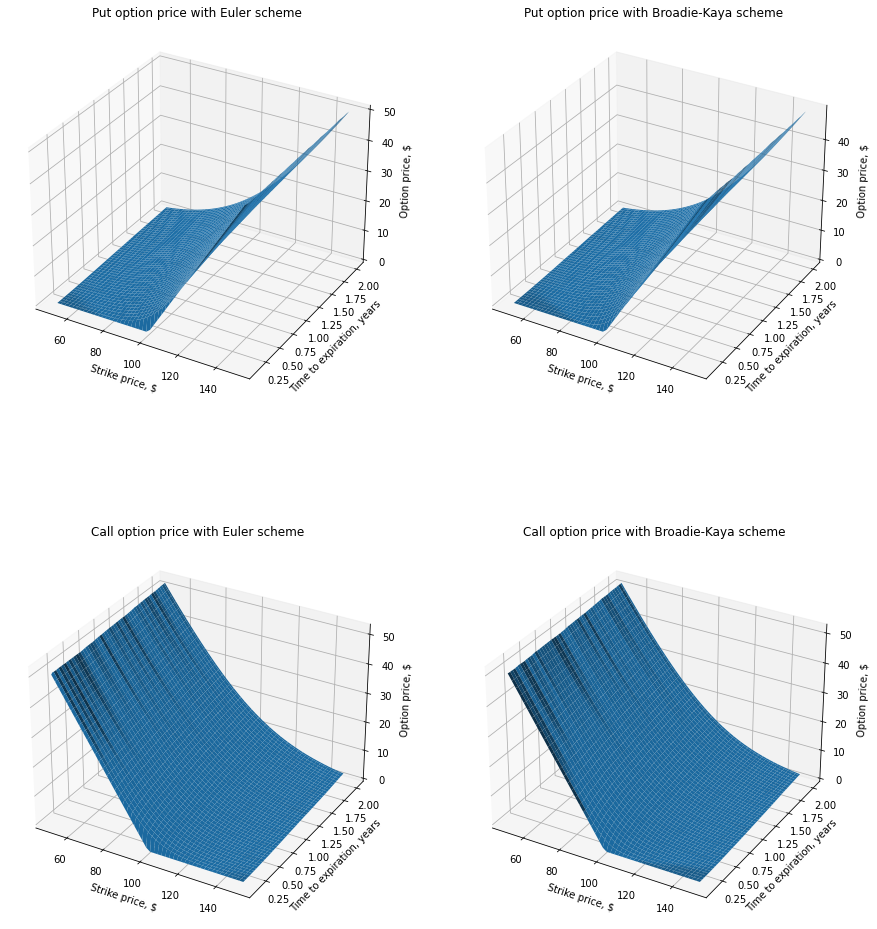

In [38]:
fig = plt.figure(figsize=(15, 35))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price_euler)
ax1.set_title('Call option price with Euler scheme')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(x, y, call_price_bk)
ax1.set_title('Call option price with Broadie-Kaya scheme')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')


ax2 = fig.add_subplot(221, projection='3d')
ax2.plot_surface(x, y, put_price_euler)
ax2.set_title('Put option price with Euler scheme')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x, y, put_price_bk)
ax2.set_title('Put option price with Broadie-Kaya scheme')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

---

## Episode 5: Memes (10 points) ⚰️

Come up with a funny financial math meme.
If the meme is not funny, then we will have to deduct points.
Don't steal memes, come up with your own!

В 1973 году Блэк, Шоулз и Мертон придумали способ репликации опционов в модели GBM, 
то есть с постоянной волатильностью. Они получили Нобелевскую премию, 
сначала заработали, а потом потеряли кучу денег, 
но в итоге оказалось, что реальные данные не удовлетворяют GBM, потому что волатильность не постоянная, а у нее улыбка. И самое смешное, что прошло уже 50 лет - а ничего сильно сложнее GBM не придумали 
(ну есть CEV, Heston, SABR, но все они произошли от GBM), и у них у всех есть изъяны, то есть мы (и крупные банки, например), продолжаем расчитывать цену опционов по на самом деле не вполне верной формуле! И по этим ценам (ну не по ним, а по ним+Credit Value Adjustment+маржа) действительно инструменты продаются и покупаются! То есть действительно All models are wrong, but some are useful! Это не вполне мем, но все равно забавно, на мой взгляд:)